In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)

2.2.0


In [2]:
df=pd.read_csv("data.csv")
df

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
0,2015-01-15,43.80,3112.370,45.670,16872.950,1380.00,48.60,4.120,2013.750,13727150.00,0.413363,7.614220e+05,3.038322e+05,824.000000,212403.0,1.1789,0.16140,1.52360,218.11
1,2015-01-16,43.26,3147.530,45.730,16812.960,1404.90,46.35,4.120,1992.250,13730725.00,0.382308,7.680090e+05,3.256906e+05,731.000000,219873.0,1.1633,0.16140,1.51850,205.35
2,2015-01-17,43.26,3147.530,45.730,16812.960,1342.95,47.65,4.120,1992.250,13734300.00,0.366155,6.775014e+05,2.994605e+05,633.000000,254267.0,1.1633,0.16140,1.51850,197.12
3,2015-01-18,43.26,3178.075,45.730,16906.870,1281.00,48.95,4.120,1992.250,13738025.00,0.330078,7.891797e+05,3.256906e+05,703.000000,223392.0,1.1592,0.16105,1.51770,211.18
4,2015-01-19,44.13,3208.620,46.165,17000.780,1279.40,48.84,4.120,2006.505,13741900.00,0.343386,8.261971e+05,3.388057e+05,740.000000,197559.0,1.1551,0.16070,1.51690,212.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172,2020-12-26,54.92,3542.850,127.980,26708.100,1877.30,48.09,4.080,3694.030,18581006.25,1.285844,2.379213e+07,1.336463e+08,2110.423611,662980.0,1.2186,0.15310,1.35570,23715.53
2173,2020-12-27,55.09,3548.490,128.530,26699.695,1882.15,48.16,4.105,3708.530,18581887.50,1.384866,2.372233e+07,1.271496e+08,1999.664234,627843.0,1.2194,0.15300,1.35515,24693.58
2174,2020-12-28,55.26,3554.130,129.080,26691.290,1887.00,48.23,4.130,3723.030,18582762.50,1.303960,2.753362e+07,1.373587e+08,2087.871622,696527.0,1.2202,0.15290,1.35460,26443.21
2175,2020-12-29,54.61,3580.450,129.650,26936.380,1878.00,47.72,4.140,3750.010,18583856.25,1.296632,2.996824e+07,1.479380e+08,1931.143750,717073.0,1.2217,0.15300,1.34500,26246.58


In [3]:
df.iloc[1082]

date                                2018-01-01
dow(USD)                             64.910000
euro_stoxx50(USD)                  3570.140000
nasdaq(USD)                          78.555000
nikkei(USD)                       23053.795000
oro(USD)                           1305.800000
petroleo(USD)                        60.260000
shangai_stock_exchange(USD)           3.570000
sp_500(USD)                        2752.800000
BCHAIN-TOTBC                   16774500.000000
BCHAIN-AVBLS                          1.037057
BCHAIN-MIREV (USD)             35435185.862500
BCHAIN-HRATE                   15177350.249500
BCHAIN-NTRBL                       1781.730061
BCHAIN-NADDU                     678712.000000
eur_usd                               1.200300
cny_usd                               0.153700
gbp_usd                               1.351500
BCHAIN-MKPRU (USD)                14165.575000
Name: 1082, dtype: object

In [4]:
#plt.plot(df.iloc[1900:,0], df.iloc[1900:,-1])

In [5]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg





In [6]:
ventana=2 # Se puede mover 
n_cols=19
values = df.iloc[1082:,1:].values# Desde el primer dia del 2018

scaler = MinMaxScaler(feature_range=(0, 10))
values = scaler.fit_transform(values)

data = series_to_supervised(values, ventana,1 )

In [7]:
data

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t)
2,10.000000,7.990043,0.564329,5.899993,1.157774,8.234642,5.862069,3.166518,0.000000,6.115161,...,0.022580,6.158688,8.494152,0.180962,6.014824,7.261453,8.266373,9.033816,7.985258,4.947446
3,10.000000,8.301338,0.836043,6.102299,2.756168,8.733644,6.758621,3.602686,0.010772,6.179034,...,0.033421,6.402501,8.270977,0.090481,8.752944,8.426239,7.944414,9.009662,7.985258,4.967355
4,10.000000,7.041817,0.942870,4.851022,2.307516,8.377689,4.827586,2.908997,0.022580,6.158688,...,0.045022,6.405727,8.962597,0.161573,8.793144,10.000000,7.622455,8.985507,7.985258,5.028709
5,10.000000,7.401883,1.485524,5.102325,2.309811,8.766356,4.827586,2.663743,0.033421,6.402501,...,0.054896,6.423934,8.735349,0.000000,8.102124,7.766441,5.503577,8.067633,6.360126,5.858045
6,10.000000,7.761949,2.028178,5.353628,2.312106,9.155023,4.206897,2.418488,0.045022,6.405727,...,0.066497,6.292396,10.000000,0.161573,6.750968,7.775789,5.503577,5.797101,6.058266,5.918973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,7.610619,7.805444,8.216442,9.159132,7.715433,6.885119,9.586207,9.616391,9.969721,8.227781,...,9.979388,8.627316,4.517538,8.073400,6.618370,4.738985,8.227848,6.666667,7.265707,8.605222
1091,7.610619,7.805444,8.216442,9.225556,7.715433,6.885119,9.379310,9.616391,9.974554,8.468397,...,9.984256,9.627197,4.500976,7.636017,6.044014,4.267089,8.271877,6.618357,7.246402,9.015971
1092,7.610619,7.805444,8.216442,9.225556,7.715433,6.885119,9.379310,9.616391,9.979388,8.627316,...,9.989090,8.810239,5.405210,8.323334,6.501424,5.189527,8.315905,6.570048,7.227097,9.750758
1093,7.651280,7.843595,8.301595,9.217907,7.771084,6.892881,9.551724,9.715754,9.984256,9.627197,...,9.995132,8.736246,5.982826,9.035579,5.688694,5.465463,8.398459,6.618357,6.890137,9.668180


In [8]:
entrenamiento=800
n_obs=ventana*n_cols

train=data.iloc[:entrenamiento,:]
test =data.iloc[entrenamiento:,:]

train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(800, 38) (800,)
(293, 38) (293,)


In [9]:
train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))

In [10]:
test_X.shape

(293, 2, 19)

In [11]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[train_X.shape[1],train_X.shape[2]]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(40,activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 500.0)# se puede mover entre 500 a unos 2000
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),metrics=["mae"])
history = model.fit(train_X,train_y,shuffle=False,validation_data=(test_X,test_y),epochs=1000)# epocas se pueden mover, ver la grafica del trainning

_loss: 1.3291 - val_mae: 1.7643
Epoch 852/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.9498 - mae: 2.4049 - val_loss: 1.3314 - val_mae: 1.7667
Epoch 853/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.9121 - mae: 2.3642 - val_loss: 1.3330 - val_mae: 1.7684
Epoch 854/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.8428 - mae: 2.2899 - val_loss: 1.3342 - val_mae: 1.7693
Epoch 855/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.9117 - mae: 2.3705 - val_loss: 1.3350 - val_mae: 1.7697
Epoch 856/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.7846 - mae: 2.2380 - val_loss: 1.3356 - val_mae: 1.7699
Epoch 857/1000
25/25 [==============================] - 0s 6ms/step - loss: 1.8101 - mae: 2.2619 - val_loss: 1.3371 - val_mae: 1.7707
Epoch 858/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.7971 - mae: 2.2560 - val_loss: 1.3394 - val_mae: 1.7720
Epoch 859/1000
25/25 [========

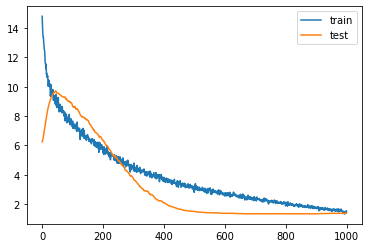

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
y_pred=model.predict(test_X)

(200.0, 300.0, -5.0, 20.0)

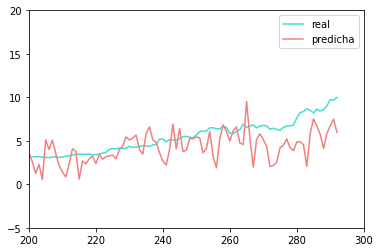

In [14]:
plt.plot(test_y, color="turquoise",label="real")
plt.plot(y_pred, color="lightcoral",label="predicha")
plt.legend()
plt.axis([200,300,-5,20])

In [15]:
y_pred=model.predict(train_X)

(400.0, 600.0, -5.0, 10.0)

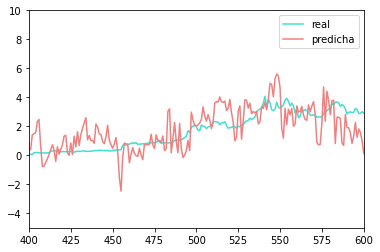

In [16]:
plt.plot(train_y, color="turquoise",label="real")
plt.plot(y_pred, color="lightcoral",label="predicha")
plt.legend()
plt.axis([400,600,-5,10])

In [17]:
    # make a prediction
    # yhat = model.predict(test_X)
    # test_X = test_X.reshape((test_X.shape[0], ventana*n_cols))
    # invert scaling for forecast
    # inv_yhat = concatenate((yhat, test_X[:, -19:]), axis=1)
    # inv_yhat = scaler.inverse_transform(inv_yhat)
    # inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    # test_y = test_y.reshape((len(test_y), 1))
    # inv_y = concatenate((test_y, test_X[:, -18:]), axis=1)
    # inv_y = scaler.inverse_transform(inv_y)
    # inv_y = inv_y[:,0]
